# Map plots to create Figure 1

Note: needs to be run with an environment that has cartopy.

In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from cmcrameri import cm
from matplotlib.colors import to_hex
import seaborn as sns
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [8]:
INPUT_TYPE = "MeteoSuisse"

KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
    FOLD = 'kfold'
else:
    NUM_FOLDS = 1
    FOLD = 'single_fold'
    # --------------------------------------------------
# PATHS:
# Path to point mass balance
path_index_raw = '../../../data/MB_modeling/GLAMOS/index/dat_files/'
mb_path = "../../../data/MB_modeling/GLAMOS/index/csv_files/massbalance/"
path_latloncoord = mb_path + "WGSlatloncoord/"  # lat-lon coord
path_GLAMOS_csv = mb_path + "raw_csv/"  # raw glamos data
path_glacattr = mb_path + "glacierattr/"  # lat-lon coord + gl attributes from oggm

# Path to ERA5-land
path_ERA5 = "../../../data/MB_modeling/ERA5/"
path_era5_stakes = (path_ERA5 + "ERA5Land-stakes/"
                    )  # path to era land at stakes coordinates
path_glogem = "../../../data/GloGEM/dataframes/"
path_ERA5_Land = path_ERA5 + "ERA5-Land/"  # whole ERA5-land
path_ERA5_Land_hourly = path_ERA5 + "/ERA5-Land-hourly/ncfiles/"
path_GLAMOS = '../../../data/MB_modeling/GLAMOS/'

# Path XGBoost and PDD model
path_pickles = "../../../data/MB_modeling/PDD/"
path_save_xgboost = "../../../data/MB_modeling/XGBoost/"
path_save_xgboost_stakes = "../../../data/MB_modeling/XGBoost/ind_stakes/"

# Path linear model
path_save_LM = "../../../data/MB_modeling/LinearModel/"
path_save_LM_stakes = "../../../data/MB_modeling/LinearModel/ind_stakes/"

# Path meteo suisse:
path_MS = '../../../data/MB_modeling/MeteoSuisse/stakes/'
path_meteogrid = '../../../data/MB_modeling/MeteoSuisse/'
path_prec = path_meteogrid + 'RhiresM_verified/lonlat/'
path_temp = path_meteogrid + '/TabsM_verified/lonlat/'

# columns of interest in glamos data:
COI = [
    "glims_id",
    "sgi_id",
    "rgi_id",
    "glims_id",
    "vaw_id",
    "date_fix0",
    "date_fix1",
    "lat",
    "lon",
    "height",
    "b_a_fix",
    "b_w_fix",
    "aspect",
    "slope",
    "dis_from_border",
    "min_el_gl",
    "max_el_gl",
    "med_el_gl",
]

In [18]:
# gets all stakes and the number of stakes per glacier
def get_StakesNum(path_GLAMOS_csv):
    onlyfiles = [
        f for f in listdir(path_GLAMOS_csv) if isfile(join(path_GLAMOS_csv, f))
    ]
    glStakesNum, glStakes = {}, {
    }  # number of stakes per glacier and stakes names
    for f in onlyfiles:
        gl = f.split("_")[0]
        if gl not in glStakesNum.keys():
            glStakesNum[gl] = 1
            glStakes[gl] = [f]
        else:
            glStakesNum[gl] = glStakesNum[gl] + 1
            glStakes[gl].append(f)
    return glStakesNum, glStakes


def get_cmap_hex(cmap, length):
    """
    Function to get a get a list of colours as hex codes

    :param cmap:    name of colourmap
    :type cmap:     str

    :return:        list of hex codes
    :rtype:         list
    """
    # Get cmap
    rgb = plt.get_cmap(cmap)(np.linspace(0, 1, length))

    # Convert to hex
    hex_codes = [to_hex(rgb[i, :]) for i in range(rgb.shape[0])]

    return hex_codes


# Get stakes with at least N years of data
def getStakesNyears(glaciers,
                    glStakes,
                    path_glacattr,
                    path_era5_stakes,
                    input_type,
                    N=20):
    glStakes_Nyears, glStakesNum_Nyears = {}, {}
    for gl in glaciers:
        # One glacier:
        for stake in glStakes[gl]:
            # Get coordinates and time of file for this stake:
            df_stake = read_stake_csv(path_glacattr, stake)

            # Read corresponding era 5 values for this stake:
            stakeName = re.split(".csv", stake)[0][:-3]

            if input_type == "ERA5-Land":
                # Read corresponding era 5 land values for this stake:
                xr_temppr = xr.open_dataset(path_era5_stakes +
                                            f"{stakeName}_mb_full.nc").sortby(
                                                "time")

            if input_type == "MeteoSuisse":
                # Read corresponding meteo suisse values for this stake:
                xr_temppr = xr.open_dataset(
                    path_MS + f"{stakeName}_mb_full.nc").sortby("time")

            begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
            end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year

            # MB data:
            # Check for missing data:
            checkMissingYears(df_stake)

            # Cut MB data to same years as xr era 5:
            df_stake_cut = cutStake(df_stake, begin_xr, end_xr)

            # Remove cat 0
            target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]

            # Keep at least N years:
            if len(target_DF) >= N:
                # print(stake, len(target_DF))
                glStakes_Nyears = updateDic(glStakes_Nyears, gl, stake)

    for gl in glStakes_Nyears.keys():
        glStakesNum_Nyears[gl] = len(glStakes_Nyears[gl])

    glStakes_Nyears_sorted = sorted(glStakesNum_Nyears.items(),
                                    key=lambda x: x[1])
    return glStakes_Nyears, glStakes_Nyears_sorted


# Reads the dataframe of a stake for one glacier
def read_stake_csv(path, fileName, coi=COI):
    dfStake = pd.read_csv(path + fileName,
                          sep=",",
                          parse_dates=["date_fix0", "date_fix1"],
                          header=0).drop(["Unnamed: 0"], axis=1)
    # removes dupl years
    dfStake = dfStake.drop_duplicates()
    dfStake = remove_dupl_years(dfStake).sort_values(by="date_fix0")
    # select only columns of interest
    dfStake = dfStake[coi]
    return dfStake


# Checks for duplicate years for a stake
def remove_dupl_years(df_stake):
    all_years = []
    rows = []
    for row_nb in range(len(df_stake)):
        year = df_stake.date_fix0.iloc[row_nb].year
        if year not in all_years:
            all_years.append(year)
            rows.append(row_nb)
    return df_stake.iloc[rows]


# Checks if there is data missing for a stake
def checkMissingYears(df_stake):
    years_stake = []
    for date in df_stake.date_fix0:
        years_stake.append(date.year)

    missing_years = Diff(
        years_stake,
        [j for j in range(years_stake[0], years_stake[-1] + 1, 1)])
    if len(missing_years) > 0:
        print("Missing years:", missing_years)


# difference between two lists
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif


# Cuts the dataframe of a stake so that it's the same
# time period as ERA5 data
def cutStake(df_stake, begin_xr, end_xr):
    start_year = df_stake.date_fix0.iloc[0].year
    end_year = df_stake.date_fix1.iloc[-1].year
    
    # print(start_year, end_year, begin_xr, end_xr)

    offset_begin = abs(begin_xr - start_year)
    offset_end = abs(end_xr - end_year)

    df_stake = df_stake.iloc[offset_begin:len(df_stake) - offset_end]
    return df_stake


# Updates a dictionnary at key with value
def updateDic(dic, key, value):
    if key not in dic.keys():
        dic[key] = [value]
    else:
        dic[key].append(value)

    return dic


# Creates a Dataframe to plot a heatmap for variable var over all stakes
def createHeatMatrixStakes(path_glacattr, glStakes, coi, var="b_a_fix"):
    glaciers = list(glStakes.keys())
    s_end, gl_mb, height = {}, {}, {}
    start_years, end_years = [], []

    # Get values for Heatmap for all stakes
    for g in range(len(glaciers)):
        gl = glaciers[g]  # One glacier
        for stake in glStakes[gl]:
            # Get coordinates and time of file for this stake:
            fileName = re.split(".csv", stake)[0][:-3]
            df_stake = read_stake_csv(path_glacattr, stake,
                                      coi).sort_values(by="date_fix0")

            # remove category 0
            df_stake = df_stake[df_stake.vaw_id > 0]

            # years:
            years = [
                df_stake.date_fix0.iloc[i].year
                for i in range(len(df_stake.date_fix0))
            ]

            start_years.append(years[0])
            end_years.append(years[-1])

            s_end[fileName] = years  # start and end years
            gl_mb[fileName] = df_stake[var].values  # MB of stake
            height[fileName] = df_stake.height.iloc[0]  # Height of stake

    # Sort stakes per elevation
    stakes_per_el = pd.Series(height).sort_values(ascending=False).index

    # Create DF with MB for each year for all stakes
    totalDF = pd.DataFrame(
        data={
            "years": range(np.min(start_years),
                           np.max(end_years) +
                           1),  # total years over all stakes
            "pres": np.ones((np.max(end_years) + 1) -
                            np.min(start_years)),  # unimportant column
        })

    for stake in stakes_per_el:
        fileName = re.split(".csv", stake)[0]
        start_year, end_year = s_end[fileName][0], s_end[fileName][-1]
        year_gl = pd.DataFrame(
            data={
                "years":
                s_end[fileName],  # Years where stake has been measured
                fileName: gl_mb[fileName],  # MB for that stake
            })
        totalDF = pd.merge(totalDF, year_gl, on="years",
                           how="left")  # Add that stake to DF
    totalDF = totalDF.set_index("years").drop(["pres"], axis=1)
    return totalDF

In [19]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())
# Keep only the glaciers with more than 20 years of measurements
glStakes_20years, glStakes_20years_sorted = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type=INPUT_TYPE,
    N=20)
print('After preprocessing:\n----\nNumber of glaciers:',
      len(glStakes_20years.keys()))
num_stakes = 0
for gl in glStakes_20years.keys():
    num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', num_stakes)

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
Missing years: [2016, 2017, 2018, 2019, 2020]
After preprocessing:
----
Number of glaciers: 13
Number of stakes: 29


### Stakes:

In [22]:
len_stakes = {}
for gl in glStakes_20years:
    # One glacier:
    for stake in glStakes_20years[gl]:
        # Get coordinates and time of file for this stake:
        df_stake = read_stake_csv(path_glacattr, stake)

        # Read corresponding era 5 values for this stake:
        stakeName = re.split(".csv", stake)[0][:-3]

        if INPUT_TYPE == "ERA5-Land":
            # Read corresponding era 5 land values for this stake:
            xr_temppr = xr.open_dataset(
                path_era5_stakes + f"{stakeName}_mb_full.nc").sortby("time")

        if INPUT_TYPE == "MeteoSuisse":
            # Read corresponding meteo suisse values for this stake:
            xr_temppr = xr.open_dataset(
                path_MS + f"{stakeName}_mb_full.nc").sortby("time")

        begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
        end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year
        
        # print(stakeName, begin_xr, end_xr)

        # MB data:
        # Check for missing data:
        checkMissingYears(df_stake)

        # Cut MB data to same years as xr era 5:
        df_stake_cut = cutStake(df_stake, begin_xr, end_xr)
        # print(df_stake_cut)

        # Remove cat 0
        target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]

        # Keep at least N years:
        len_stakes[stakeName] = len(target_DF)

stakes_info = pd.DataFrame({
    'stakes': len_stakes.keys(),
    'Numb. meas.': len_stakes.values()
})
lats, lons = [], []
for stake in stakes_info.stakes:
    df_stake = read_stake_csv(path_glacattr, f'{stake}_mb.csv')
    stake_lat, stake_lon = df_stake.lat.mean(), df_stake.lon.mean()
    lats.append(stake_lat)
    lons.append(stake_lon)

stakes_info['lat'] = lats
stakes_info['lon'] = lons

glacier_correct = {'aletsch':'Aletsch', 'allalin':'Allalin', 'basodino':'Basodino', 'clariden':'Clariden', 'corbassiere':'Corbassiere',
       'gietro':'Gietro', 'gries':'Gries', 'hohlaub':'Hohlaub', 'limmern':'Limmern', 'pers':'Pers', 'plattalva':'Plattalva',
       'schwarzberg':'Schwarzberg', 'silvretta':'Silvretta'}
stakes_info['Glacier'] = [glacier_correct[stake.split('_')[0]] for stake in stakes_info.stakes]
stakes_info.sort_values(by='Glacier', inplace=True)

Missing years: [2016, 2017, 2018, 2019, 2020]


In [23]:
stakes_info

,stakes,Numb. meas.,lat,lon,Glacier
10,aletsch_P3,57,46.543322,7.983927,Aletsch
6,aletsch_P5,30,46.549202,7.994410,Aletsch
7,aletsch_P0,28,46.413423,8.054136,Aletsch
8,aletsch_P9,28,46.524852,8.006805,Aletsch
9,aletsch_P10,27,46.517550,8.019368,Aletsch
16,allalin_P1,62,46.044764,7.934793,Allalin
0,basodino_P5,32,46.417478,8.478760,Basodino
1,basodino_P8,32,46.413681,8.473084,Basodino
2,basodino_P10,32,46.416416,8.493087,Basodino
15,clariden_L,62,46.855238,8.910585,Clariden


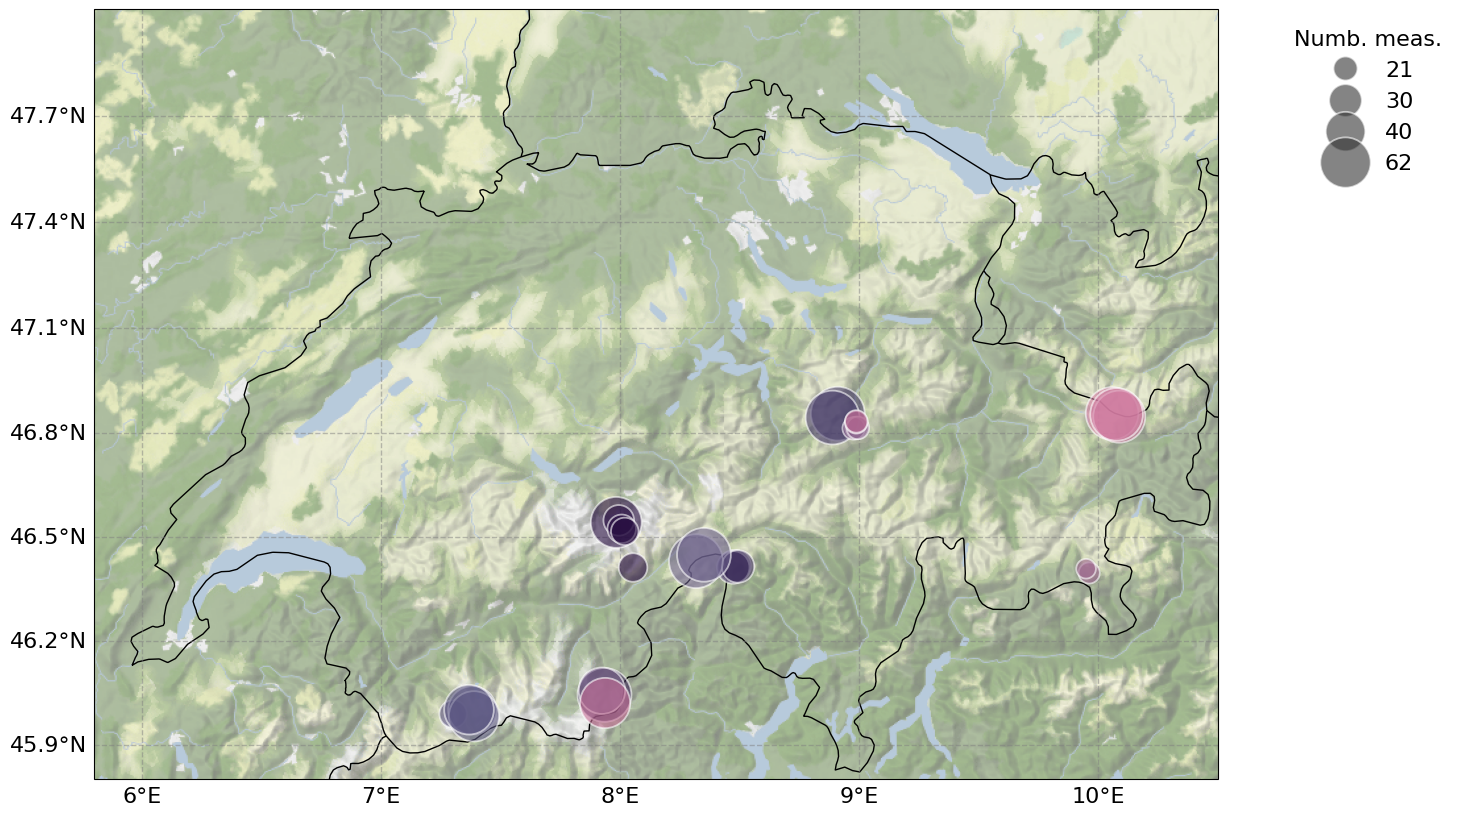

In [27]:
# Create the figure object
fig = plt.figure(
    figsize=(15, 10)
)  # Notice we need a bigger "canvas" so these two maps will be of a decent size

# Set the domain for defining the second plot region.
latN = 48
latS = 45.8
lonW = 5.8
lonE = 10.5
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2


# Add background image:
class StadiaStamen(cimgt.Stamen):
    def _image_url(self, tile):
        x, y, z = tile
        API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
        url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.png?api_key={API_KEY}"
        # url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}.png?api_key={API_KEY}"
        return url


stamen_terrain = StadiaStamen("terrain-background")
projPC = ccrs.PlateCarree()

# Create a Geoax2es in the tile's projection.
ax2 = plt.axes(projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax2.set_extent([lonW, lonE, latS, latN], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 8.
ax2.add_image(stamen_terrain, 8, alpha=0.7)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)

cmap = cm.acton
color_palette_glaciers = sns.color_palette(
    get_cmap_hex(cmap, 20))

g = sns.scatterplot(stakes_info,
                    x='lon',
                    y='lat',
                    size="Numb. meas.",
                    hue="Glacier",
                    sizes=(200, 1500),
                    alpha=.6,
                    palette=color_palette_glaciers,
                    transform=projPC,
                    ax=ax2,
                    zorder = 10)
h, l = g.get_legend_handles_labels()

# Pick only important information
# h_sub, l_sub = [h[14]]+h[15:18]+[h[19]], [l[14]]+l[15:18]+[l[19]]
h_sub, l_sub = h[15:18]+[h[19]], l[15:18]+[l[19]]
l_sub = ['21', '30', '40', '62']

ax2.legend(h_sub,
           l_sub,
           bbox_to_anchor=(1.05, 1),
           loc=2,
        #    ncol=2,
           borderaxespad=0.5,
           frameon=False,
           fontsize=16,
           markerscale=1,
           title = 'Numb. meas.',
           title_fontsize = 16)


# kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",
#           func=lambda s: np.sqrt(s/.3)/3)
# legend2 = ax.legend(*scatter.legend_elements(**kw),
#                     loc="lower right", title="Price")

gl = ax2.gridlines(draw_labels=True,
                   linewidth=1,
                   color='gray',
                   alpha=0.5,
                   linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}
gl.top_labels = gl.right_labels = False

### Glaciers:

In [11]:
df_info_gl = pd.DataFrame(
    stakes_info.groupby('Glacier').sum()['Numb. meas.']).reset_index()
df_info_gl_loc = pd.DataFrame(
    stakes_info[['Glacier', 'lat',
                 'lon']].groupby('Glacier').mean()).reset_index()
df_info_gl = df_info_gl.merge(df_info_gl_loc, on='Glacier')
# df_info_gl['range'] = pd.cut(df_info_gl['num_meas'], [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])

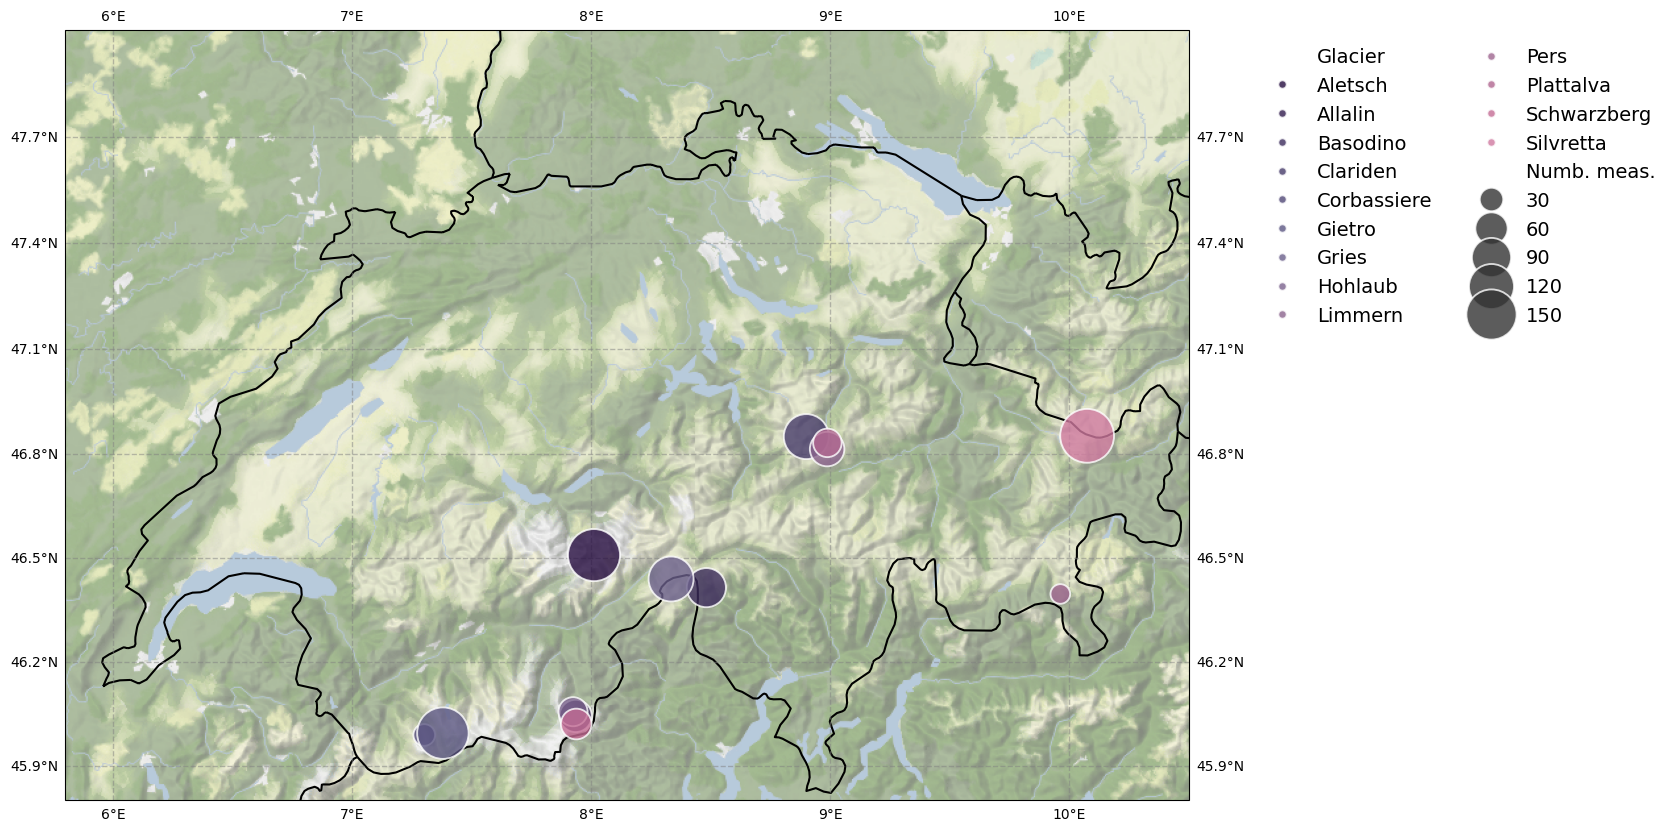

In [13]:

# Create the figure object
fig = plt.figure(
    figsize=(15, 10)
)  # Notice we need a bigger "canvas" so these two maps will be of a decent size

# Set the domain for defining the second plot region.
latN = 48
latS = 45.8
lonW = 5.8
lonE = 10.5
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2


# Add background image:
class StadiaStamen(cimgt.Stamen):
    def _image_url(self, tile):
        x, y, z = tile
        API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
        url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.png?api_key={API_KEY}"
        # url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}.png?api_key={API_KEY}"
        return url


stamen_terrain = StadiaStamen("terrain-background")
projPC = ccrs.PlateCarree()

# Create a Geoax2es in the tile's projection.
ax2 = plt.axes(projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax2.set_extent([lonW, lonE, latS, latN], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 8.
ax2.add_image(stamen_terrain, 8, alpha=0.7)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)

cmap = cm.acton
color_palette_glaciers = sns.color_palette(
    get_cmap_hex(cmap, 20))
# color_palette_glaciers = sns.color_palette("deep")

g = sns.scatterplot(df_info_gl,
                    x='lon',
                    y='lat',
                    size="Numb. meas.",
                    hue="Glacier",
                    sizes=(200, 1500),
                    alpha=.8,
                    palette=color_palette_glaciers,
                    transform=projPC,
                    ax=ax2,
                    zorder = 10)
h, l = g.get_legend_handles_labels()

ax2.legend(h,
           l,
           bbox_to_anchor=(1.05, 1),
           loc=2,
           ncol=2,
           borderaxespad=0.5,
           frameon=False,
           fontsize=14,
           markerscale=1)
gl = ax2.gridlines(draw_labels=True,
                   linewidth=1,
                   color='gray',
                   alpha=0.5,
                   linestyle='--')